In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import TimeSeriesSplit
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.utils import shuffle

from keras.models import Sequential
from keras.layers import InputLayer, LSTM, Dense, Dropout
from keras.optimizers import Adam
from keras.losses import MeanSquaredError
from keras.metrics import RootMeanSquaredError
from keras.constraints import MaxNorm
from keras.callbacks import ModelCheckpoint

In [2]:
filepath = 'C:/Users/ss230/Documents/Study/NSIDC/Edited Data/S_Sea_Ice_Index_Regional_Monthly_Data_G02135_v3.0.xlsx'
Weddell_Extent = pd.read_excel(filepath, sheet_name='Weddell-Extent-km^2')

In [3]:
import sys
sys.path.append('C:/Users/ss230/Documents/Study/NSIDC/SH/Bi_LSTM_Extent/')
import Function as fp

In [4]:
fp.month_mapping(Weddell_Extent)
fp.date_time(Weddell_Extent)

,Extent,Date
0,2136510.859,1979-01-01
1,1243495.891,1979-02-01
2,1699053.449,1979-03-01
3,2617442.085,1979-04-01
4,3852934.206,1979-05-01
...,...,...
533,3668127.143,2023-06-01
534,4805519.784,2023-07-01
535,5524445.234,2023-08-01
536,6006669.861,2023-09-01


In [5]:
scaler = MinMaxScaler()
Weddell_Extent['Extent'] = scaler.fit_transform(Weddell_Extent['Extent'].values.reshape(-1, 1))

In [6]:
def df_to_X_y(df, window_size):
    df_as_np = df.to_numpy()
    X = []
    y = []
    lead_time = 9
    for i in range(len(df_as_np) - window_size - lead_time + 1):
        window_data = df_as_np[i:i+window_size]
        row = [[a] for a in window_data]
        X.append(row)
        label = df_as_np[i+window_size+lead_time-1]
        y.append(label)
    return np.array(X), np.array(y)

In [7]:
extent = Weddell_Extent['Extent']
W_S=12
X,y = df_to_X_y(extent, W_S)
X.shape, y.shape

((518, 12, 1), (518,))

In [8]:
X_train, y_train = X[:420], y[:420]
X_val, y_val = X[420:472], y[420:472]
X_test, y_test = X[472:], y[472:]

In [9]:
model = Sequential()
model.add(InputLayer((W_S, 1)))
model.add(LSTM(128, activation='relu', kernel_constraint=MaxNorm(1.0), return_sequences=True))
model.add(Dropout(0.5))
model.add(LSTM(64, activation='relu', kernel_constraint=MaxNorm(1.0), return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(32, activation='relu', kernel_constraint=MaxNorm(1.0)))
model.add(Dense(1, activation='linear'))

cp = ModelCheckpoint('Weddell_model_LT9/', save_best_only=True)
model.compile(loss=MeanSquaredError(), optimizer=Adam(0.0001), metrics=[RootMeanSquaredError()])

In [10]:
import time

stime = time.time()
history = model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=50, batch_size=8, callbacks=[cp])
etime = time.time()

Epoch 1/50
53/53 [==============================] - 12s 145ms/step - loss: 0.2879 - root_mean_squared_error: 0.5365 - val_loss: 0.2172 - val_root_mean_squared_error: 0.4660
Epoch 2/50
53/53 [==============================] - 8s 145ms/step - loss: 0.1499 - root_mean_squared_error: 0.3872 - val_loss: 0.1174 - val_root_mean_squared_error: 0.3427
Epoch 3/50
53/53 [==============================] - 8s 148ms/step - loss: 0.1091 - root_mean_squared_error: 0.3304 - val_loss: 0.1013 - val_root_mean_squared_error: 0.3182
Epoch 4/50
53/53 [==============================] - 8s 150ms/step - loss: 0.0984 - root_mean_squared_error: 0.3137 - val_loss: 0.0901 - val_root_mean_squared_error: 0.3002
Epoch 5/50
53/53 [==============================] - 8s 150ms/step - loss: 0.0849 - root_mean_squared_error: 0.2914 - val_loss: 0.0769 - val_root_mean_squared_error: 0.2773
Epoch 6/50
53/53 [==============================] - 8s 148ms/step - loss: 0.0712 - root_mean_squared_error: 0.2669 - val_loss: 0.0608 - val

Epoch 36/50
53/53 [==============================] - 1s 23ms/step - loss: 0.0077 - root_mean_squared_error: 0.0878 - val_loss: 0.0086 - val_root_mean_squared_error: 0.0928
Epoch 37/50
53/53 [==============================] - 1s 22ms/step - loss: 0.0075 - root_mean_squared_error: 0.0866 - val_loss: 0.0086 - val_root_mean_squared_error: 0.0927
Epoch 38/50
53/53 [==============================] - 1s 23ms/step - loss: 0.0072 - root_mean_squared_error: 0.0847 - val_loss: 0.0070 - val_root_mean_squared_error: 0.0838
Epoch 39/50
53/53 [==============================] - 1s 24ms/step - loss: 0.0072 - root_mean_squared_error: 0.0846 - val_loss: 0.0084 - val_root_mean_squared_error: 0.0916
Epoch 40/50
53/53 [==============================] - 1s 21ms/step - loss: 0.0071 - root_mean_squared_error: 0.0840 - val_loss: 0.0106 - val_root_mean_squared_error: 0.1029
Epoch 41/50
53/53 [==============================] - 7s 134ms/step - loss: 0.0077 - root_mean_squared_error: 0.0876 - val_loss: 0.0068 - val

In [11]:
time = (etime - stime)/60
print(f'{time} minutes')

2.7717201511065164 minutes


In [12]:
loss = history.history['loss']
epochs = list(range(1, len(loss) + 1))

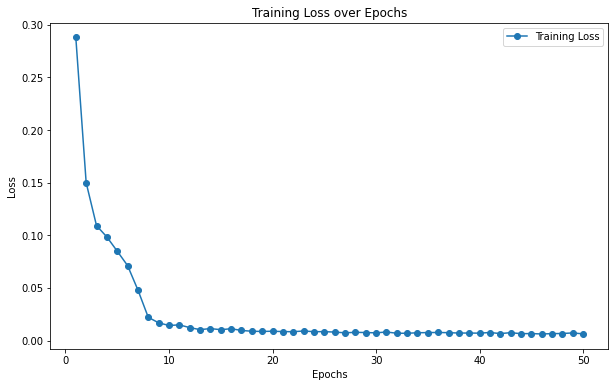

In [13]:
plt.figure(figsize=(10, 6))
plt.plot(epochs, loss, label='Training Loss', marker='o', linestyle='-')

plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training Loss over Epochs')
plt.legend()
plt.show()

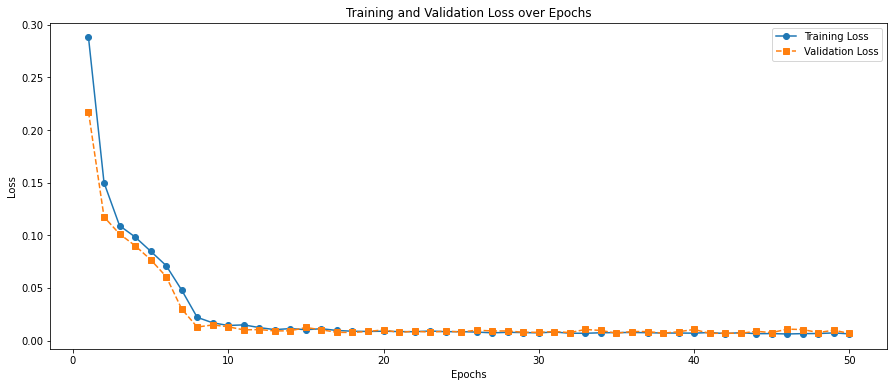

In [14]:
training_loss = history.history['loss']
validation_loss = history.history['val_loss']
epochs = range(1, len(training_loss) + 1)

plt.figure(figsize=(15,6))
plt.plot(epochs, training_loss, label='Training Loss', marker='o', linestyle='-')
plt.plot(epochs, validation_loss, label='Validation Loss', marker='s', linestyle='--')

plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss over Epochs')
plt.legend()
plt.show()

In [15]:
from tensorflow.keras.models import load_model
model1 = load_model('Weddell_model_LT9/')

In [16]:
test_predictions = model1.predict(X_test)

2/2 [==============================] - 1s 16ms/step


In [17]:
mse = mean_squared_error(y_test, test_predictions)
print('RMSE :', np.sqrt(mse))

mae = mean_absolute_error(y_test, test_predictions)
print('MAE :', mae)

RMSE : 0.07906943903677105
MAE : 0.06018144128315596


In [18]:
test_predictions = scaler.inverse_transform(test_predictions)
test_original = scaler.inverse_transform(y_test.reshape(-1,1))

In [19]:
train_results = pd.DataFrame(data={'Train Predictions': test_predictions.flatten(), 'Actual Extent': test_original.flatten()})
train_results

,Train Predictions,Actual Extent
0,3070897.750,1633675.726
1,1737685.250,1292668.399
2,1725276.250,1527666.815
3,2620089.250,2121949.701
4,3935200.250,3562381.775
5,5018991.000,5004305.983
6,5889572.500,6176613.878
7,6412505.500,6794233.093
8,6612310.000,7024136.637
9,6479906.500,6554271.388


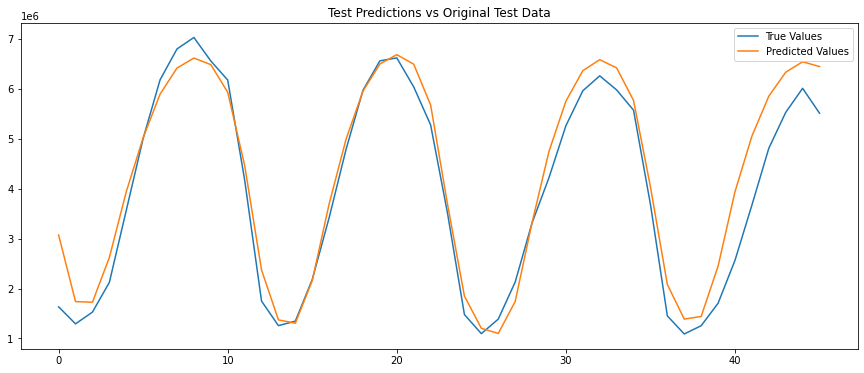

In [20]:
plt.figure(figsize=(15,6))
plt.plot(test_original, label='True Values')
plt.plot(test_predictions, label='Predicted Values')
plt.title('Test Predictions vs Original Test Data')
plt.legend()
plt.show()

In [21]:
predictions = model1.predict(X)

17/17 [==============================] - 0s 11ms/step


In [22]:
predictions = scaler.inverse_transform(predictions)
Original = scaler.inverse_transform(y.reshape(-1,1))

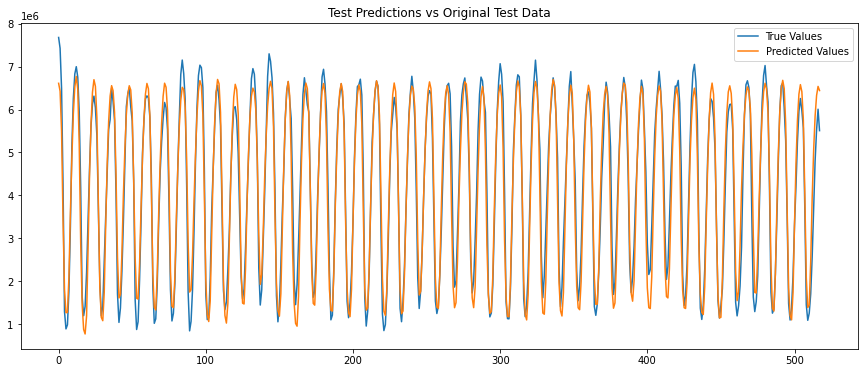

In [23]:
plt.figure(figsize=(15,6))
plt.plot(Original, label='True Values')
plt.plot(predictions, label='Predicted Values')
plt.title('Test Predictions vs Original Test Data')
plt.legend()
plt.show()